In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-match-probability-prediction/sample_submission.csv
/kaggle/input/football-match-probability-prediction/train_target_and_scores.csv
/kaggle/input/football-match-probability-prediction/train.csv
/kaggle/input/football-match-probability-prediction/test.csv


In [2]:
#import modules
from sklearn import metrics, model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

#loading the data
train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')
test = pd.read_csv('/kaggle/input/football-match-probability-prediction/test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    return df

In [4]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    home_has_coach_change = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    home_has_coach_change = home_has_coach_change.apply(lambda x: np.multiply(x, 1) )
    away_has_coach_change = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    away_has_coach_change = away_has_coach_change.apply(lambda x: np.multiply(x, 1) )
    new_columns = {'home_has_coach_change': home_has_coach_change, 'away_has_coach_change': away_has_coach_change}
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    return df

In [5]:
def get_median(a):
    if a.size == 0 or all(np.isnan(a)):
        return np.NaN
    else:
        return np.nanmedian(a)

In [6]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [7]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        df[f'home_team_history_match_interval_{i}'] = train.apply( lambda r:
            (pd.Timestamp(r['match_date'])-pd.Timestamp(r[f'home_team_history_match_date_{i}']))
            /np.timedelta64(1, "D") 
            ,axis=1).astype('float32')
        df[f'away_team_history_match_interval_{i}'] = train.apply( lambda r:
            (pd.Timestamp(r['match_date'])-pd.Timestamp(r[f'away_team_history_match_date_{i}']))
            /np.timedelta64(1, "D") 
            ,axis=1).astype('float32')
    return df

In [8]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    for i in range(1,11):
        df[f'home_team_history_goal_difference_{i}']=df[f'home_team_history_goal_{i}']-df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_goal_difference_{i}']=df[f'away_team_history_goal_{i}']-df[f'away_team_history_opponent_goal_{i}']
        df[f'home_team_history_rating_difference_{i}']=df[f'home_team_history_rating_{i}']-df[f'home_team_history_opponent_rating_{i}']
        df[f'away_team_history_rating_difference_{i}']=df[f'away_team_history_rating_{i}']-df[f'away_team_history_opponent_rating_{i}']
    for i in [5,10]:
        df[f'home_team_history_average_goal_scored_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'away_team_history_average_goal_scored_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'home_team_history_average_goal_conceded_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_opponent_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'away_team_history_average_goal_conceded_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_opponent_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        df[f'home_team_history_average_point_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_goal_difference_{j}'] for j in range (1,i+1)).apply(result_point).mean(), axis=1)
        df[f'away_team_history_average_point_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_goal_difference_{j}'] for j in range (1,i+1)).apply(result_point).mean(), axis=1) 
        df[f'home_team_history_median_rating_difference_{i}']=df.apply(lambda r: get_median(pd.Series(r[f'home_team_history_rating_difference_{j}'] for j in range (1,i+1))), axis=1)
        df[f'away_team_history_median_rating_difference_{i}']=df.apply(lambda r: get_median(pd.Series(r[f'away_team_history_rating_difference_{j}'] for j in range (1,i+1))), axis=1)
    return df

In [9]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=add_match_interval(df)
    df=add_form_features(df)
    return df

In [10]:
train_p=preprocession(train)

In [11]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11978898
target home
home_team_name Akwa Starlets
away_team_name Warri Wolves
match_date 2019-12-01 15:00:00
league_name Npfl
league_id 1475
is_cup 0.0
home_team_coach_id 37252510.0
away_team_coach_id 37252510.0
home_team_history_match_date_1 2019-11-24 15:00:00
home_team_history_match_date_2 2019-11-21 15:00:00
home_team_history_match_date_3 2019-11-17 15:00:00
home_team_history_match_date_4 nan
home_team_history_match_date_5 nan
home_team_history_match_date_6 nan
home_team_history_match_date_7 nan
home_team_history_match_date_8 nan
home_team_history_match_date_9 nan
home_team_history_match_date_10 nan
home_team_history_is_play_home_1 0.0
home_team_history_is_play_home_2 1.0
home_team_history_is_play_home_3 0.0
home_team_history_is_play_home_4 nan
home_team_history_is_play_home_5 nan
home_team_history_is_play_home_6 nan
home_team_history_is_play_home_7 nan
home_team_history_is_play_home_8 nan
home_team_history_is_play_home_9 nan
home_team_history_is_play_home_10 nan
home_team_histo

In [12]:
match_date_columns=[col for col in train_p.columns if ('match_date' in col)]
match_date_columns

['match_date',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'away_team_history_match_date_1',
 'away_team_history_match_date_2',
 'away_team_history_match_date_3',
 'away_team_history_match_date_4',
 'away_team_history_match_date_5',
 'away_team_history_match_date_6',
 'away_team_history_match_date_7',
 'away_team_history_match_date_8',
 'away_team_history_match_date_9',
 'away_team_history_match_date_10']

In [13]:
history_rating_columns=[col for col in train_p.columns if ((('history_rating' in col) | ('history_opponent_rating' in col)) & ('difference' not in col))]
history_rating_columns

['home_team_history_rating_1',
 'home_team_history_rating_2',
 'home_team_history_rating_3',
 'home_team_history_rating_4',
 'home_team_history_rating_5',
 'home_team_history_rating_6',
 'home_team_history_rating_7',
 'home_team_history_rating_8',
 'home_team_history_rating_9',
 'home_team_history_rating_10',
 'home_team_history_opponent_rating_1',
 'home_team_history_opponent_rating_2',
 'home_team_history_opponent_rating_3',
 'home_team_history_opponent_rating_4',
 'home_team_history_opponent_rating_5',
 'home_team_history_opponent_rating_6',
 'home_team_history_opponent_rating_7',
 'home_team_history_opponent_rating_8',
 'home_team_history_opponent_rating_9',
 'home_team_history_opponent_rating_10',
 'away_team_history_rating_1',
 'away_team_history_rating_2',
 'away_team_history_rating_3',
 'away_team_history_rating_4',
 'away_team_history_rating_5',
 'away_team_history_rating_6',
 'away_team_history_rating_7',
 'away_team_history_rating_8',
 'away_team_history_rating_9',
 'away_te

In [14]:
X=train_p.drop(match_date_columns, axis=1)
X=X.drop(['id','home_team_name','away_team_name','league_name','target'], axis=1)
y=train_p['target']

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [16]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [17]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [18]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.05,
    'min_split_loss': 0.05,
    'min_child_weight': 5,
    'subsample': 0.7,
    'sample_type': 'uniform',
    'normalize_type': 'tree',
    'objective': 'multi:softprob',
    'num_class': 3,
    'rate_drop': 0.1,
    'eval_metric':'mlogloss'
    }

num_round = 300
evallist = [(d_test, 'eval'), (d_train, 'train')]

In [19]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=5)

[21:01:05] WARNING: ../src/learner.cc:576: 
Parameters: { "normalize_type", "rate_drop", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-mlogloss:1.09309	train-mlogloss:1.09265
[1]	eval-mlogloss:1.08795	train-mlogloss:1.08704
[2]	eval-mlogloss:1.08323	train-mlogloss:1.08185
[3]	eval-mlogloss:1.07887	train-mlogloss:1.07704
[4]	eval-mlogloss:1.07481	train-mlogloss:1.07260
[5]	eval-mlogloss:1.07104	train-mlogloss:1.06842
[6]	eval-mlogloss:1.06751	train-mlogloss:1.06448
[7]	eval-mlogloss:1.06427	train-mlogloss:1.06082
[8]	eval-mlogloss:1.06126	train-mlogloss:1.05740
[9]	eval-mlogloss:1.05844	train-mlogloss:1.05416
[10]	eval-mlogloss:1.05578	train-mlogloss:1.05113
[11]	eval-mlogloss:1.05330	train-mlogloss:1.04828
[12]	eval-mloglos

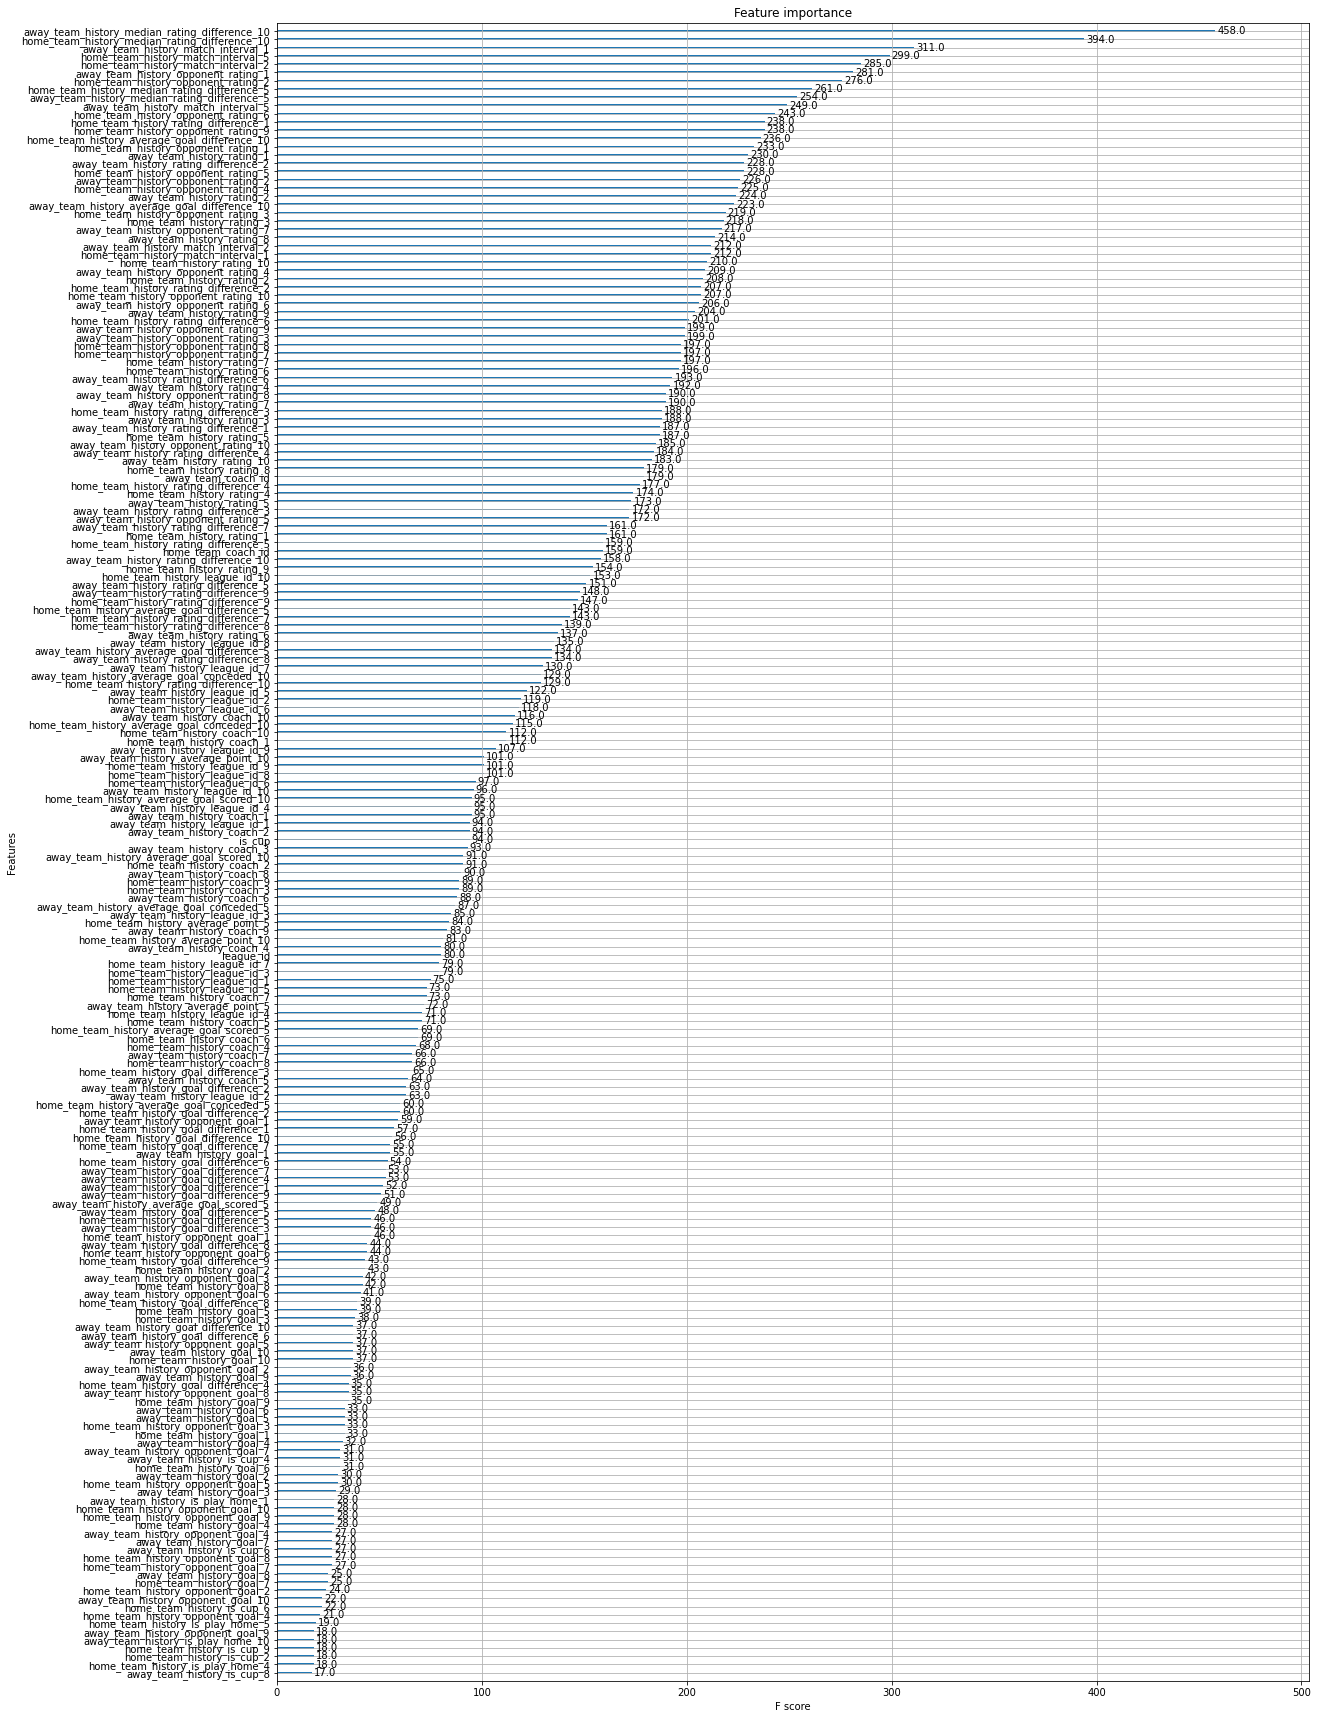

In [20]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

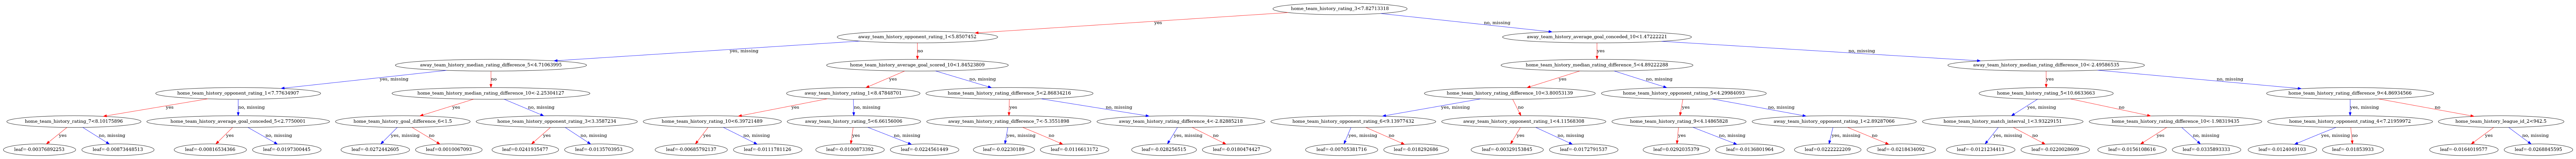

In [21]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [22]:
test_p=preprocession(test)

In [23]:
X_test=test_p.drop(match_date_columns, axis=1)
X_test=X_test.drop(['id','home_team_name','away_team_name','league_name'], axis=1)
X_test_d = xgb.DMatrix(X_test)

In [24]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [25]:
predictions

array([[0.23263992, 0.27733752, 0.49002257],
       [0.39477694, 0.31543204, 0.28979102],
       [0.29167745, 0.3165921 , 0.39173052],
       ...,
       [0.5150684 , 0.24214065, 0.2427909 ],
       [0.17687587, 0.25022775, 0.5728964 ],
       [0.29894614, 0.331636  , 0.36941782]], dtype=float32)

In [26]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test['id']
display(submission)

,away,draw,home,id
0,0.232640,0.277338,0.490023,17761448
1,0.394777,0.315432,0.289791,17695487
2,0.291677,0.316592,0.391731,17715496
3,0.564855,0.276742,0.158402,17715493
4,0.225325,0.322042,0.452633,17715492
...,...,...,...,...
72706,0.305425,0.349563,0.345012,18450246
72707,0.188836,0.209208,0.601956,18164889
72708,0.515068,0.242141,0.242791,18449018
72709,0.176876,0.250228,0.572896,17958831


In [27]:
submission.to_csv('submission.csv', index=False)